In [60]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata/data?select=tmdb_5000_movies.csv

### LOAD DATA
----

In [27]:
df_movies = pd.read_csv('data/tmdb_5000_movies.csv')
df_movies.head(5)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


### EDA
----

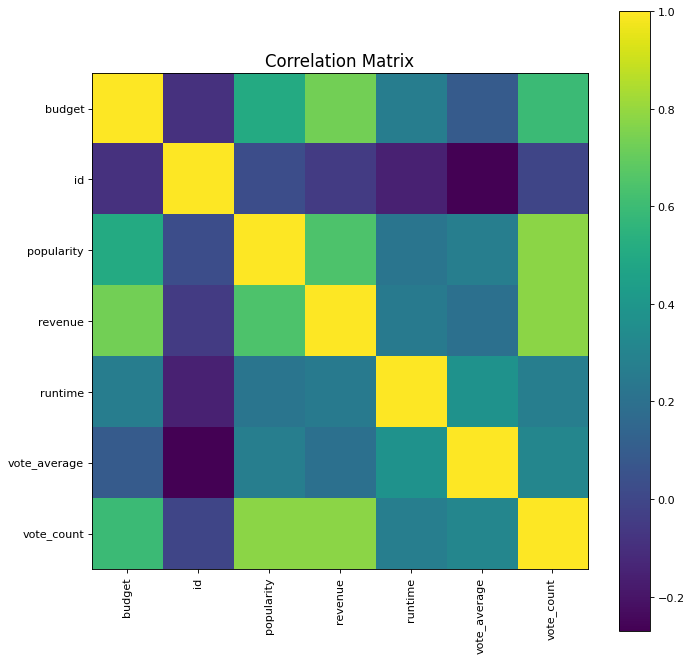

In [14]:
def plotCorrelationMatrix(df, graphWidth):
    # Select only numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    df_numeric = df_numeric[[col for col in df_numeric if df_numeric[col].nunique() > 1]]
    
    corr = df_numeric.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

plotCorrelationMatrix(df_movies, graphWidth=10)

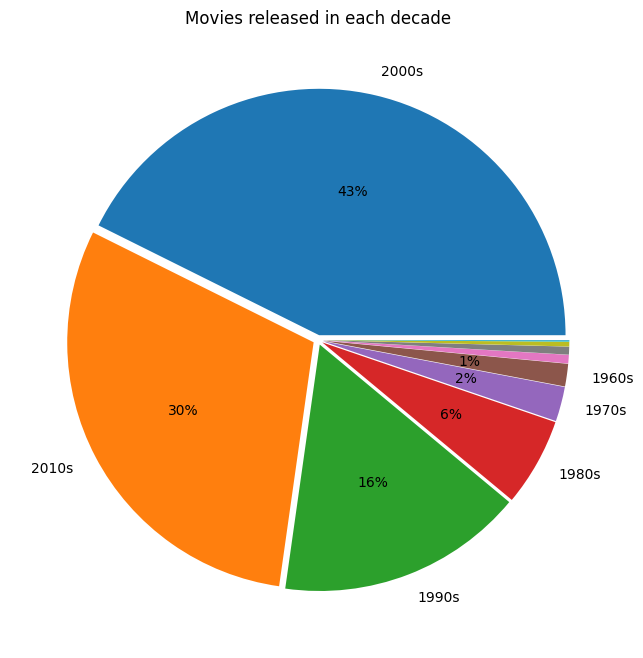

In [16]:
# numbers of movies released in each decade
def count_pie(series):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(8, 8))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    plt.title('Movies released in each decade')
    plt.show()

def count_decade_pie(df):
    count_pie(df.release_date.dropna().apply(lambda x:str(int(x[:4])//10*10)+'s'))
    
count_decade_pie(df_movies)

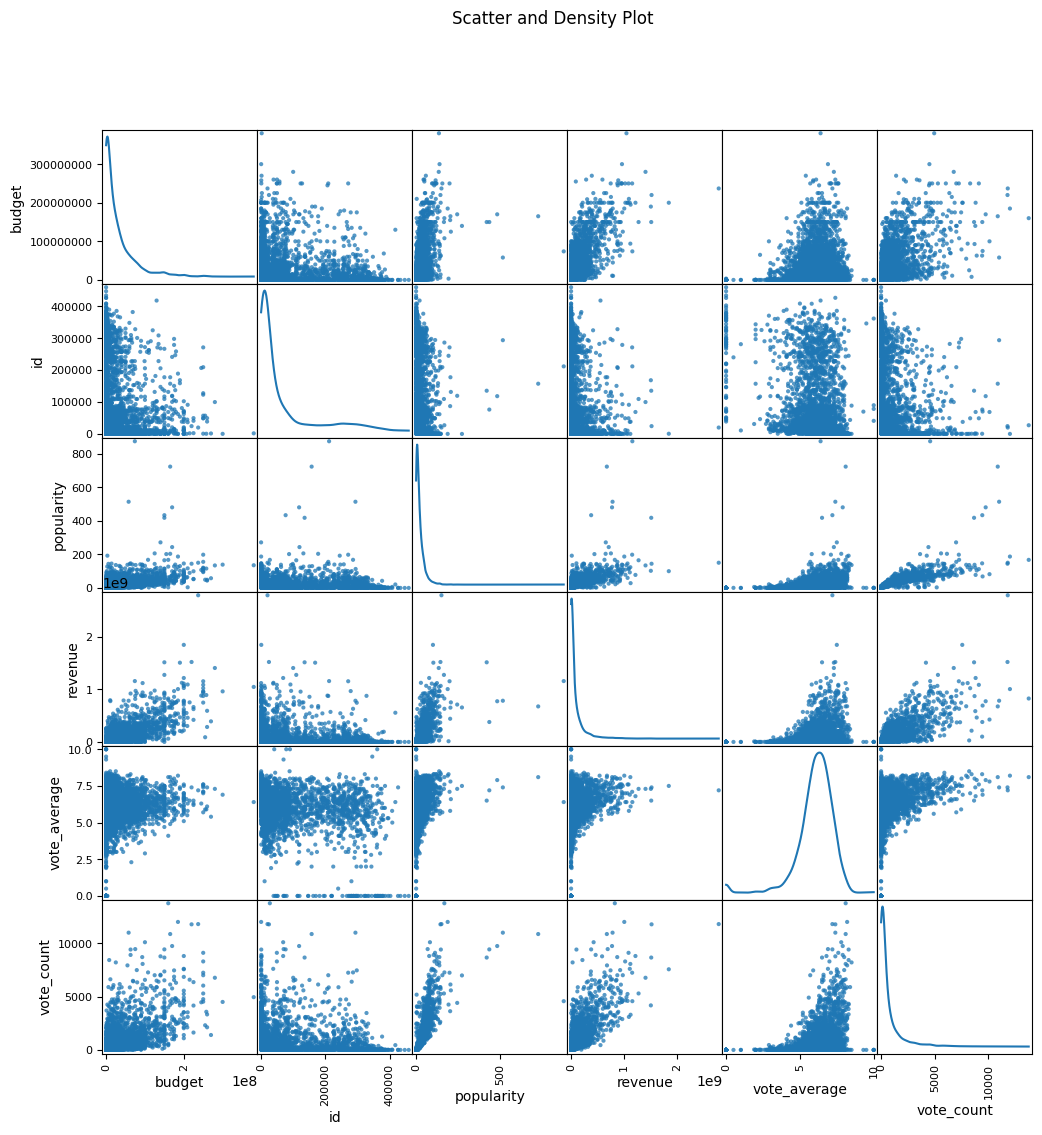

In [23]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) 
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] 
    columnNames = list(df)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    plt.suptitle('Scatter and Density Plot')
    plt.show()

plotScatterMatrix(df_movies, plotSize=12, textSize=10)

### FEATURE ENGINEERING
---

In [33]:
df_features = df_movies.copy()
df_features.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [34]:
df_features['release_date'] = pd.to_datetime(df_features['release_date'], errors='coerce')
df_features['release_year'] = df_features['release_date'].dt.year.fillna(0).astype(int)

# df_features['budget'] = pd.to_numeric(df_features['budget'], errors='coerce').fillna(0)
df_features['runtime'] = pd.to_numeric(df_features['runtime'], errors='coerce').fillna(0)
df_features['vote_average'] = pd.to_numeric(df_features['vote_average'], errors='coerce').fillna(0)
df_features['vote_count']   = pd.to_numeric(df_features['vote_count'], errors='coerce').fillna(0)

df_features['genres'] = df_features['genres'].apply(lambda x: [g['name'] for g in ast.literal_eval(x)] if pd.notnull(x) else [])
num_df_features = df_features[['runtime', 'vote_average', 'vote_count', 'release_year']]


In [35]:
mlb = MultiLabelBinarizer()
genre_ohe = mlb.fit_transform(df_features['genres'])
genre_cols = [f"genre_{g}" for g in mlb.classes_]
genre_df = pd.DataFrame(genre_ohe, columns=genre_cols, index=df_features.index)
genre_df.head()

,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_Foreign,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western
0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [36]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
lang_ohe = ohe.fit_transform(df_features[['original_language']]) 
lang_cols = [f"lang_{cat}" for cat in ohe.categories_[0]]
lang_df = pd.DataFrame(lang_ohe, columns=lang_cols, index=df_features.index)
lang_df.head()

,lang_af,lang_ar,lang_cn,lang_cs,lang_da,lang_de,lang_el,lang_en,lang_es,lang_fa,lang_fr,lang_he,lang_hi,lang_hu,lang_id,lang_is,lang_it,lang_ja,lang_ko,lang_ky,lang_nb,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sl,lang_sv,lang_ta,lang_te,lang_th,lang_tr,lang_vi,lang_xx,lang_zh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Combina tudo
X = pd.concat([num_df_features, genre_df, lang_df], axis=1).fillna(0)
y = df_features['popularity'].fillna(0)
X

,runtime,vote_average,vote_count,release_year,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_Foreign,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western,lang_af,lang_ar,lang_cn,lang_cs,lang_da,lang_de,lang_el,lang_en,lang_es,lang_fa,lang_fr,lang_he,lang_hi,lang_hu,lang_id,lang_is,lang_it,lang_ja,lang_ko,lang_ky,lang_nb,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sl,lang_sv,lang_ta,lang_te,lang_th,lang_tr,lang_vi,lang_xx,lang_zh
0,162.0,7.2,11800,2009,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,169.0,6.9,4500,2007,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,148.0,6.3,4466,2015,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,165.0,7.6,9106,2012,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,132.0,6.1,2124,2012,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,81.0,6.6,238,1992,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4799,85.0,5.9,5,2011,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4800,120.0,7.0,6,2013,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4801,98.0,5.7,7,2012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TRAINING
----

In [69]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10))
])

pipeline.fit(X_train, y_train)
y_pred_all = pipeline.predict(X_test)

mean_squared_error_value = mean_squared_error(y_test, pipeline.predict(X_test))


print("Trainning:")
print("RMSE:", np.sqrt(mean_squared_error_value))
print("R² test:", pipeline.score(X_test, y_test))
print("R² trainning:", pipeline.score(X_train, y_train))

Trainning:
RMSE: 17.994324528921204
R² test: 0.6810523698743469
R² trainning: 0.933766024176808


In [68]:
random_idx = np.random.choice(X_test.index)
X_sample = X_test.loc[random_idx].values.reshape(1, -1)
y_real = y_test.loc[random_idx]

y_pred = pipeline.predict(X_sample)[0]


print(f"Movie: {df_features.loc[random_idx, 'title']}")
print(f"Real popularity:     {y_real:.2f}")
print(f"Predicted popularity: {y_pred:.2f}")

Movie: Drive Hard
Real popularity:     3.94
Predicted popularity: 6.28


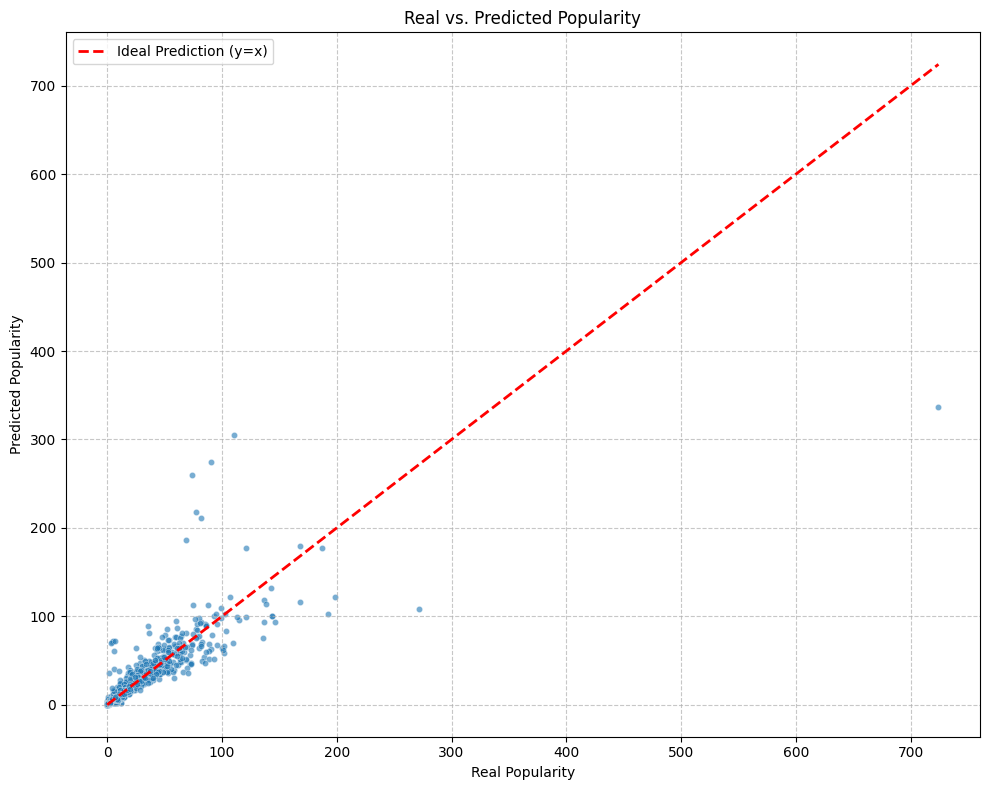

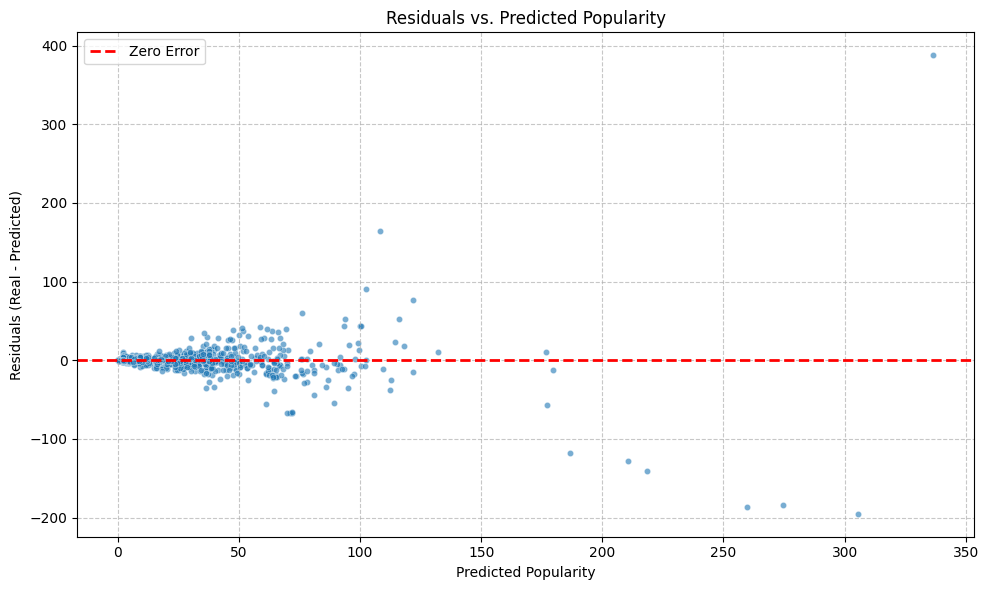

In [72]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_all, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Prediction (y=x)')
plt.title('Real vs. Predicted Popularity')
plt.xlabel('Real Popularity')
plt.ylabel('Predicted Popularity')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

residuals = y_test - y_pred_all
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_all, y=residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
plt.title('Residuals vs. Predicted Popularity')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals (Real - Predicted)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results_df = pd.DataFrame({
    'title': df_features.loc[y_test.index, 'title'], 
    'real_popularity': y_test,
    'predicted_popularity': y_pred_all,
    'absolute_error': np.abs(residuals)
})

In [82]:
best_predictions = results_df.sort_values(by='absolute_error').head(5)
print("\n--- Top 5 Best Predictions ---")
print(best_predictions[['title', 'real_popularity', 'predicted_popularity', 'absolute_error']].to_string())

worst_predictions = results_df.sort_values(by='absolute_error', ascending=False).head(5)
print("\n--- Top 5 Worst Predictions ---")
print(worst_predictions[['title', 'real_popularity', 'predicted_popularity', 'absolute_error']].to_string())


--- Top 5 Best Predictions ---
                                           title  real_popularity  predicted_popularity  absolute_error
2268  Three Kingdoms: Resurrection of the Dragon         4.127155              4.121139        0.006016
627                              The Last Legion        12.282911             12.274450        0.008461
2644                                   Ong Bak 2         9.029489              9.015688        0.013801
3907        Jason Goes to Hell: The Final Friday        10.341982             10.327849        0.014133
4351                           Sands of Iwo Jima         3.851000              3.835227        0.015773

--- Top 5 Worst Predictions ---
                                                       title  real_popularity  predicted_popularity  absolute_error
95                                              Interstellar       724.247784            336.452864      387.794920
239                                                  Gravity       110.153618  

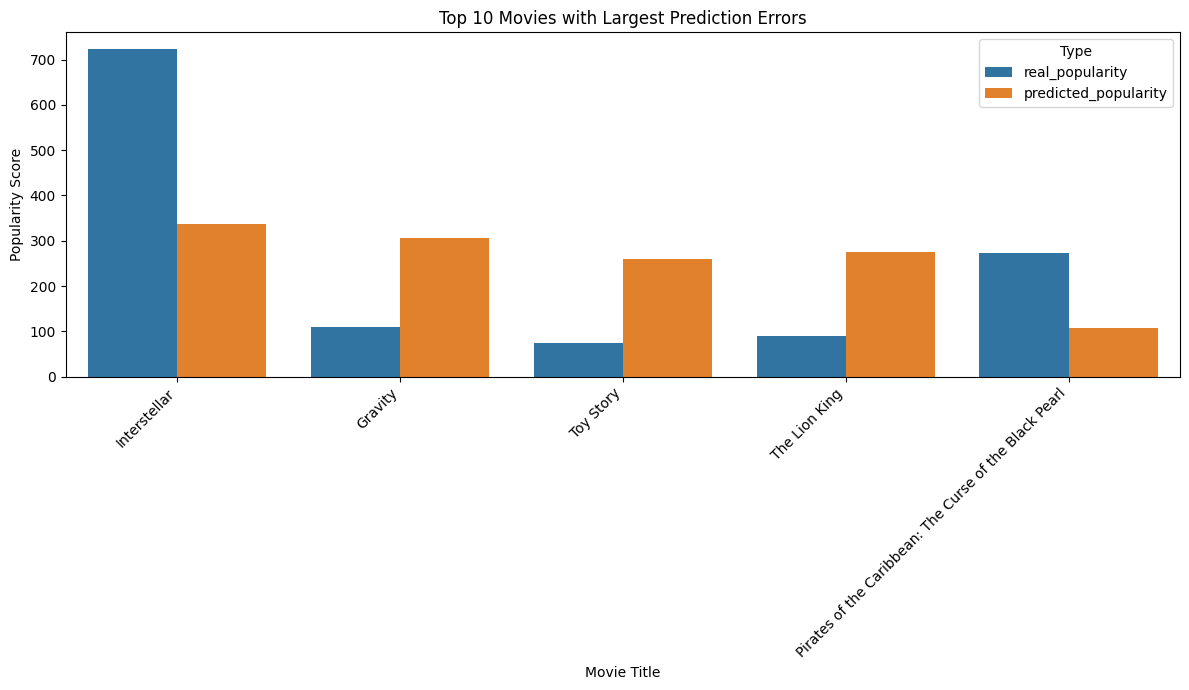

In [83]:

plt.figure(figsize=(12, 7))
worst_predictions_plot = worst_predictions.melt(id_vars=['title'], value_vars=['real_popularity', 'predicted_popularity'],
                                                 var_name='Type', value_name='Popularity')
sns.barplot(x='title', y='Popularity', hue='Type', data=worst_predictions_plot)
plt.title('Top 10 Movies with Largest Prediction Errors')
plt.xlabel('Movie Title')
plt.ylabel('Popularity Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()